In [22]:

from functools import partial

from matplotlib import pyplot as plt
from pymunk.util import *
from pymunk.util import _reduce_hulls, _attempt_reduction, is_left
from vector import Vector as v

def make_my_convexes(points:list[v]):
    print('input__', points)
    points = list(dict.fromkeys(points))
    print('reduced', points)
    hull = convex_hull(points)
    print('hulled_', hull)
    
    inside_points = []
    for i, hp in enumerate(hull):
        pass
        
    return hull

def get_all_points_from_shapes(shapes):
    return [point for shape in shapes for point in shape]

def check_point_on_segment(points:list[v]) -> list[v]:
    ''' 완전한 counterclockwise hull에 대해서만 사용 가능 '''
    # print('input__', points)
    # points = list(set(points))
    points = [v(x) for x in points]
    # points = list(dict.fromkeys(points))
    ''' 중복 제거를 할 필요 없을 듯?'''
    # print('phase_1', points)
    num = len(points)
    if num < 3:
        raise AttributeError('need more than 3 points')
    # points = tuple(points)
    bad_boys = []
    
    for i, point in enumerate(points):
        ab = point - points[i - 1]
        bc = points[i + 1 if i < num - 1 else 0] - point
        if ab.unit == bc.unit:
            bad_boys.append(point)
    
    if not bad_boys: return points
    
    for bad in bad_boys:
        points.remove(bad)
    # print('phase_2', points)
    print('points in segment reduced')
    return points

def triangulate_all(shapes:list):
    triangles = []
    for shape in shapes:
        triangles.extend(triangulate(shape))
    triangles.reverse()
    return triangles

def draw(*poly, title:str = None):
    if title is not None: print(title)
    plt.figure()
    for pl in poly:
        plts = pl[:]
        plts.append(plts[0])
        xs, ys = zip(*plts)
        plt.plot(xs, ys)
        plt.fill(xs, ys, alpha=0.2)
        
    plt.show()

boxes to optimize


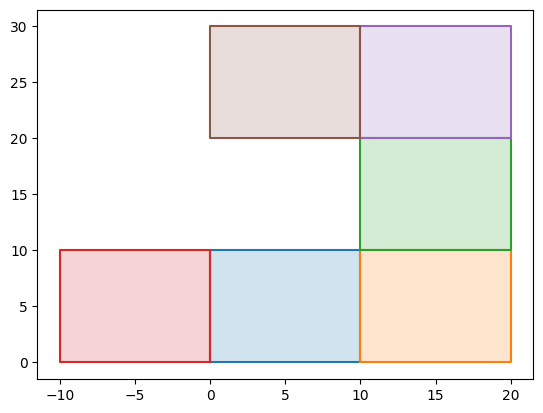

triangulate normally with boxes


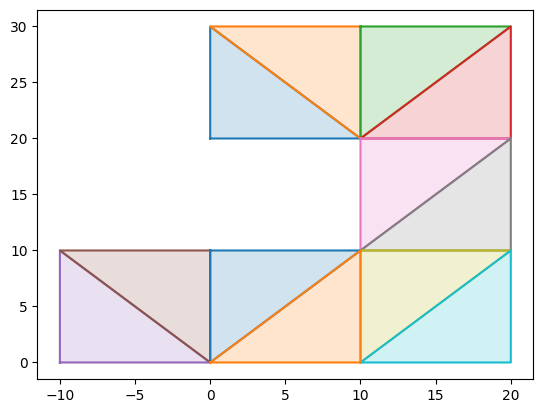

then convexed result below (same with boxes)


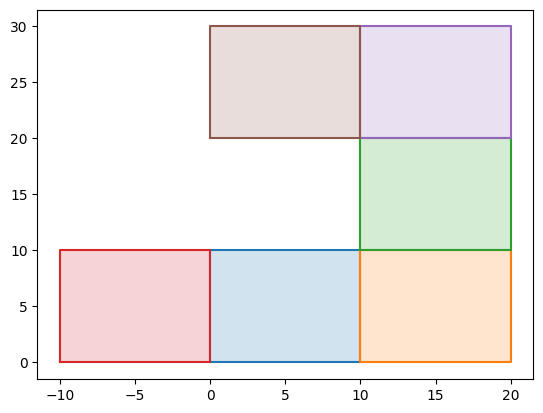

because the whole collision is below


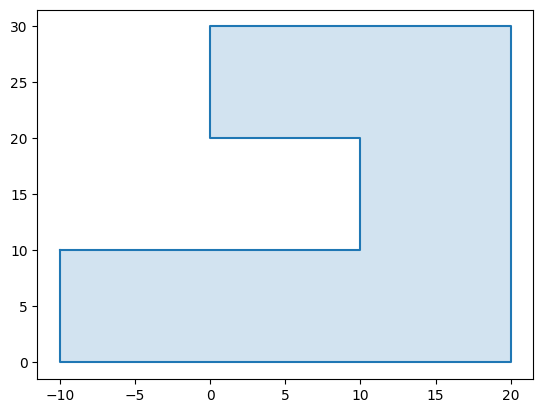

triangulated ideally


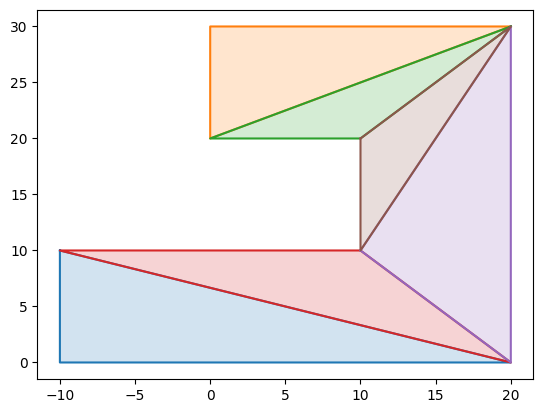

finally, ideal convex like below


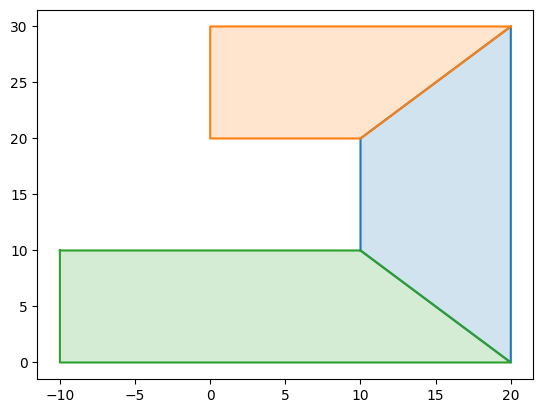

In [13]:
# a = [v(0,0), v(3,0), v(10,0), v(10,10), v(7,10), v(0,10)]
a = [v(0,0), v(10,0), v(10,10), v(0,10)]
b = [v(10,0), v(20,0), v(20,10), v(10,10)]
c = [v(10,10), v(20,10), v(20,20), v(10,20)]
d = [v(0,0), v(0,10), v(-10,10), v(-10,0)]
e = [v(10,20), v(20,20), v(20,30), v(10,30)]
f = [v(10,20), v(10,30), v(0,30), v(0,20)]

boxes = [a, b, c, d, e, f]

pts = get_all_points_from_shapes(boxes)
wp = [v(-10,10), v(-10,0), v(20,0), v(20,30), 
      v(0,30), v(0,20), v(10,20), v(10,10)]

# wp = [v(-10,30), v(-10,0), v(20,0), v(20,30), v(-10,30),
      # v(10,20), v(0,20), v(0,10), v(10,10), v(10,20)]

# triangulated_boxes = [tri for box in boxes for triangles in triangulate(box) for tri in triangles]
triangulated = triangulate_all(boxes)
draw(*boxes, title = 'boxes to optimize')
draw(*triangulated, title = 'triangulate normally with boxes')
draw(*convexise(triangulated), title = 'then convexed result below (same with boxes)')
draw(wp, title = 'because the whole collision is below')
draw(*triangulate(wp), title = 'triangulated ideally')
draw(*convexise(triangulate(wp)), title = 'finally, ideal convex like below')
# 결국, wp를 구해야 하는 문제로 귀결?

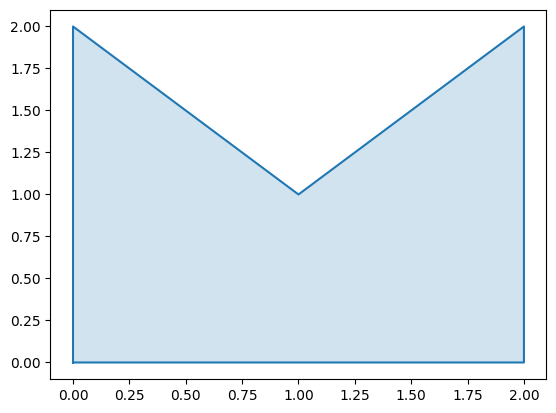

triangulated


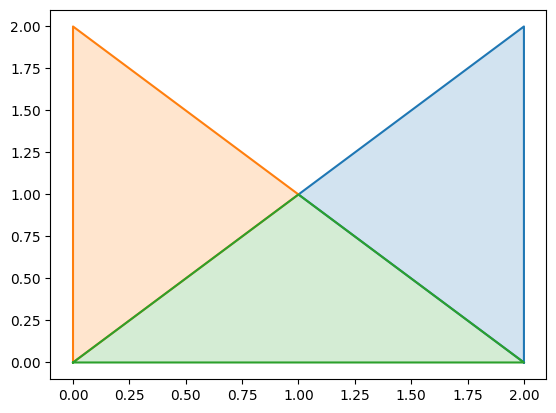

convexed


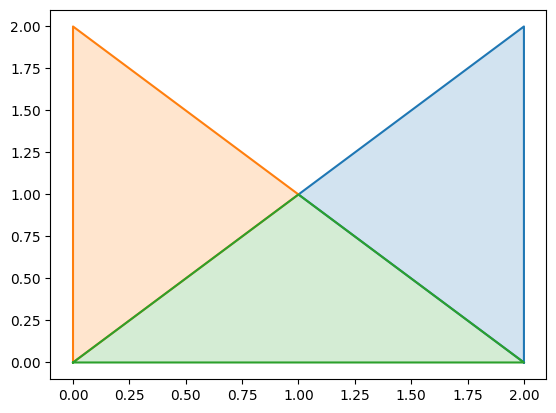

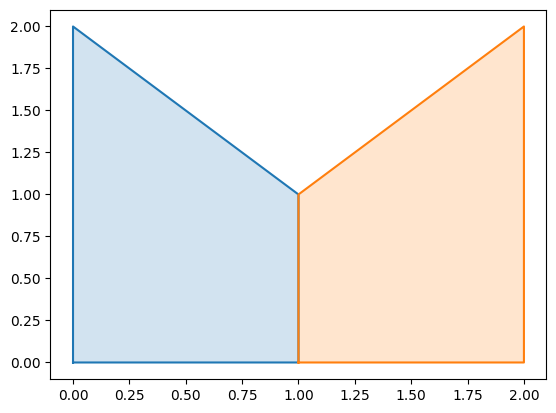

triangulated


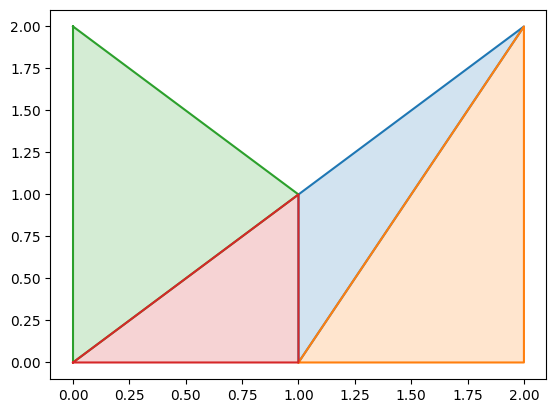

convexed


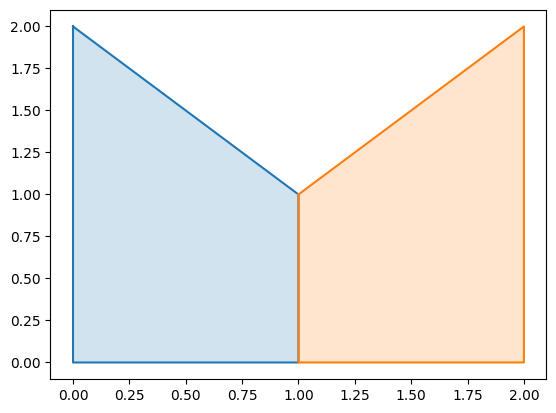

In [14]:
test_concave = [v(0,0), v(2,0), v(2,2), v(1,1), v(0,2)]
draw(test_concave)
# test_concave.append(calc_center(test_concave))
draw(*triangulate(test_concave), title='triangulated')
draw(*convexise(triangulate(test_concave)), title='convexed')
test_c1 = [v(0,0), v(1,0), v(1,1), v(0,2)]
test_c2 = [v(1,0), v(2,0), v(2,2), v(1,1)]
test_cc = [test_c1, test_c2]
draw(test_c1, test_c2)
draw(*triangulate_all(test_cc), title = 'triangulated')
draw(*convexise(triangulate_all(test_cc)), title='convexed')

hulls combined nicely


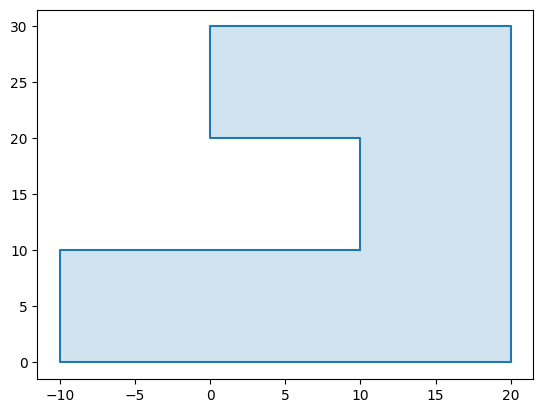

if more box added like this


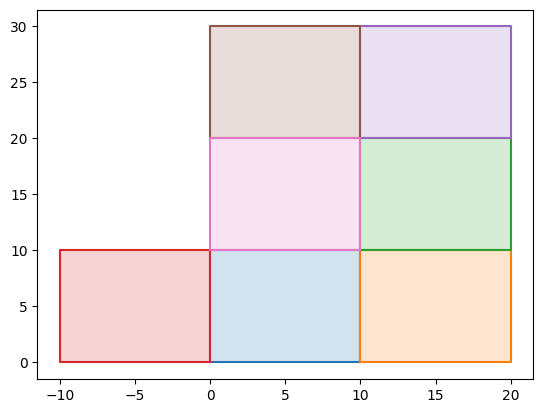

hull got error like this


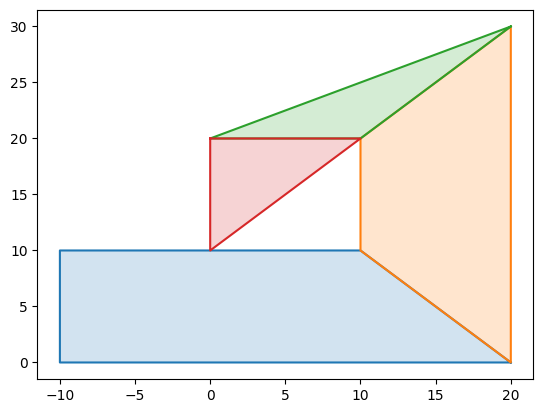

In [15]:
def _attempt_reduction(hulla:list, hullb:list):
    inter = [vec for vec in hulla if vec in hullb]
    if len(inter) == 2:
        starta = hulla.index(inter[1])
        tempa = hulla[starta:] + hulla[:starta]
        tempa = tempa[1:-1]
        startb = hullb.index(inter[0])
        tempb = hullb[startb:] + hullb[:startb]
        tempb = tempb[1:-1]
        reduced = tempa + tempb
        if is_convex(reduced):
            return reduced
    # reduction failed, return None
    return None

def _remove_last_point_and_union(hulla:list, hullb:list):
    inter = [vec for vec in hulla if vec in hullb]
    if len(inter) == 1:
        starta = hulla.index(inter[0])
        tempa = hulla[starta:] + hulla[:starta]
        tempa = tempa[1:]
        startb = hullb.index(inter[0])
        tempb = hullb[startb:] + hullb[:startb]
        tempb = tempb[1:]
        reduced = tempa + tempb
        return reduced
    return None

def _reduce_shapes(shapes:list, reduction_func):
    count = len(shapes)
    if count < 2:
        return shapes, False
    
    for ia in range(count - 1):
        for ib in range(ia + 1, count):
            reduction = reduction_func(shapes[ia], shapes[ib])
            if reduction != None:
                # they can so return a new list of hulls and a True
                newhulls = [reduction]
                for j in range(count):
                    if not (j in (ia, ib)):
                        newhulls.append(shapes[j])
                return newhulls, True

    # nothing was reduced, send the original hull list back with a False
    return shapes, False

def get_hull(shapes):
    hulls = shapes[:]
    reduced = True
    n = 0
    # keep trying to reduce until it won't reduce any more
    while reduced:
        # print('step',n,':',hulls)
        hulls, reduced = _reduce_shapes(hulls, _attempt_reduction)
        n += 1
    reduced = True
    while reduced:
        # print('step',n,':',hulls)
        hulls, reduced = _reduce_shapes(hulls, _remove_last_point_and_union)
        n += 1
    # return reduced hull list
    return hulls

def get_convexes(shapes) -> list:
    """Reduces a list of shapes to a
    non-optimum list of convex polygons

    :Parameters:
        shapes
            list of anticlockwise shapes (a list of more than three points) to reduce
    """
    hulls = shapes[:]
    reduced = True
    n = 0
    # keep trying to reduce until it won't reduce any more
    while reduced:
        # print('step',n,':',hulls)
        hulls, reduced = _reduce_shapes(hulls, _attempt_reduction)
        n += 1
    reduced = True
    while reduced:
        # print('step',n,':',hulls)
        hulls, reduced = _reduce_shapes(hulls, _remove_last_point_and_union)
        n += 1
    # return reduced hull list
    return convexise(triangulate_all(hulls))

# new_one = [v(5, 15), v(15,15), v(15,25), v(5,25)]
# new_one = [v(-10,10), v(0,10), v(0,20), v(-10,20)]
new_one = [v(0,10), v(10,10), v(10,20), v(0,20)]
# boxes.append(new_one)
boxes_more_complex = boxes[:]
boxes_more_complex.append(new_one)
draw(*get_hull(boxes), title = 'hulls combined nicely')
draw(*boxes_more_complex, title = 'if more box added like this')
draw(*get_convexes(boxes_more_complex), title = 'hull got error like this')
# draw(*get_convexes(convexise(triangulate_all(boxes_more_complex))))


chunk of boxes


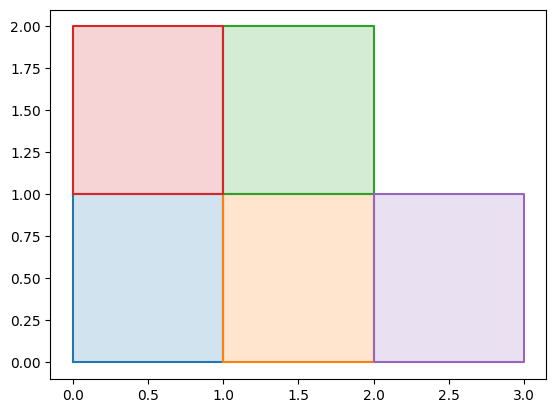

points in segment reduced
will be like below


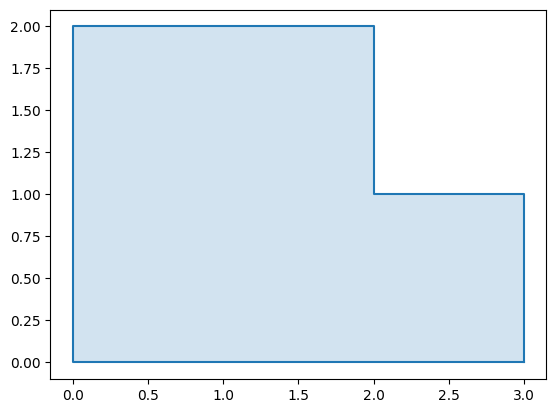

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 1
shape_a [(3, 1), (2, 1), (3, 0)]
shape_b [(2, 1), (2, 0), (3, 0)]
intersec : [(2, 1), (3, 0)]
rest_a [(3, 0), (3, 1)]
rest_b [(2, 1), (2, 0)]


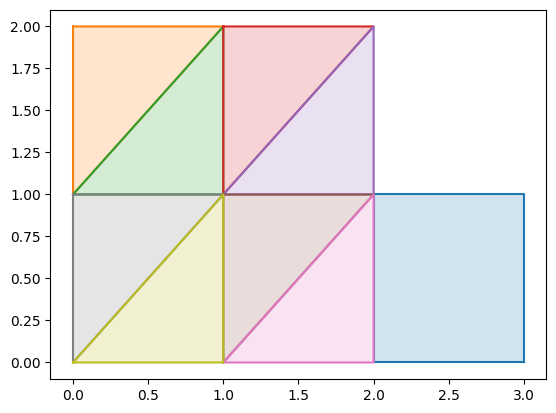

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 2
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : []
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : []
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : []
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 1), (2, 1), (2, 2)]
intersec : [(2, 1)]
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 1), (1, 0), (2, 1)]
intersec : [(2, 1)]
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 0), (2, 0), (2, 1)]
intersec : [(2, 1), (2, 0)]
rest_a [(2, 0), (3, 0), (3, 1)]
rest_b [(2, 1), (1, 0)]
points in segment reduced


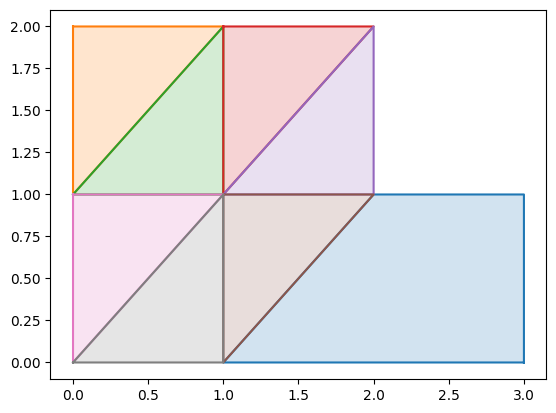

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 3
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : []
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : []
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : []
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(1, 1), (2, 1), (2, 2)]
intersec : [(2, 1)]
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(1, 1), (1, 0), (2, 1)]
intersec : [(2, 1), (1, 0)]
rest_a [(1, 0), (2, 0), (3, 0), (3, 1)]
rest_b [(2, 1), (1, 1)]
points in segment reduced


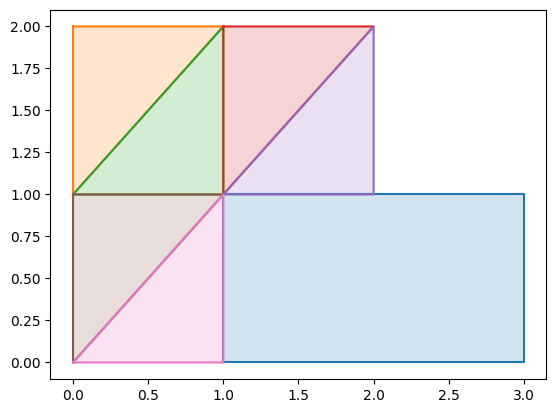

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 4
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : []
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : [(1, 1)]
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : [(1, 1)]
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(1, 1), (2, 1), (2, 2)]
intersec : [(2, 1), (1, 1)]
rest_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1)]
rest_b [(2, 1), (2, 2)]
points in segment reduced


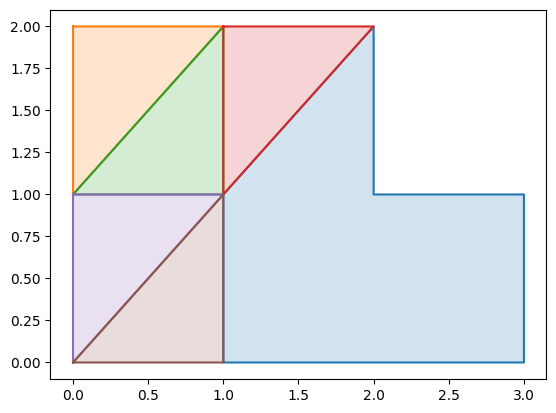

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 5
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : []
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : [(1, 1)]
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : [(1, 1), (2, 2)]
rest_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1)]
rest_b [(2, 2), (1, 2)]
points in segment reduced


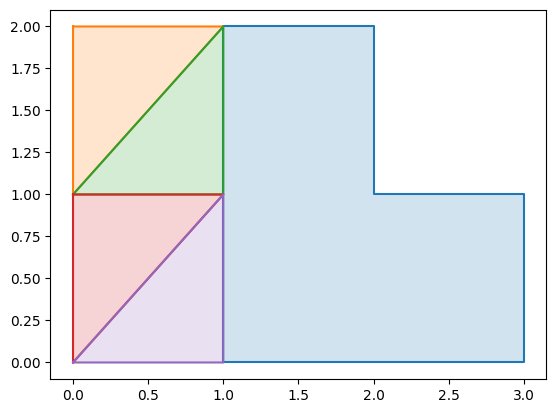

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 6
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : [(1, 2)]
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : [(1, 1), (1, 2)]
rest_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
rest_b [(1, 2), (0, 1)]
points in segment reduced


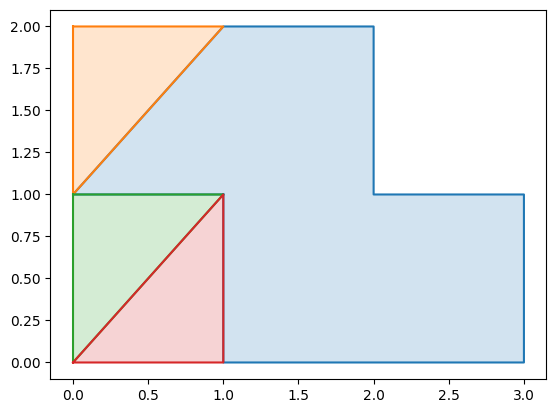

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 7
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (0, 1)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : [(1, 2), (0, 1)]
rest_a [(0, 1), (1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
rest_b [(1, 2), (0, 2)]
points in segment reduced


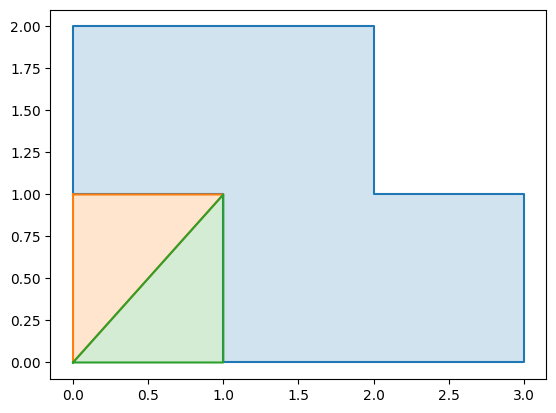

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 8
shape_a [(0, 1), (1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (0, 2)]
shape_b [(0, 1), (0, 0), (1, 1)]
intersec : [(0, 1), (1, 1)]
rest_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (0, 2)]
rest_b [(0, 1), (0, 0)]
points in segment reduced


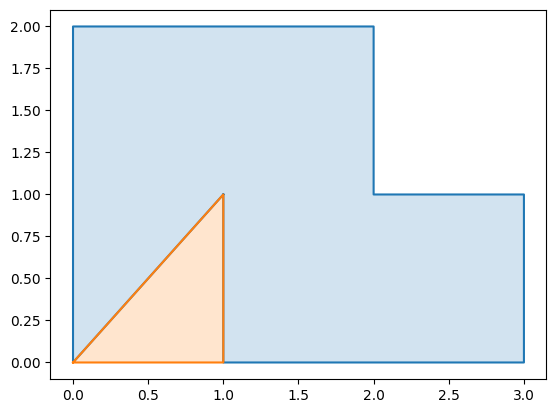

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 9
shape_a [(1, 1), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
shape_b [(0, 0), (1, 0), (1, 1)]
intersec : [(1, 1), (1, 0), (0, 0)]
intersec reduced to [(1, 0), (0, 0)]
rest_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (2, 2), (1, 2), (0, 2), (0, 1)]
rest_b [(0, 0)]
points in segment reduced


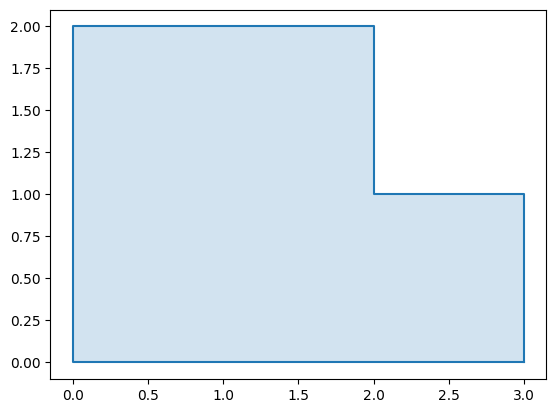

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 10
points in segment reduced


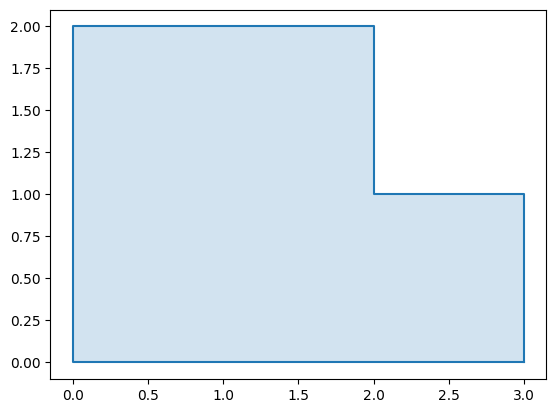

In [45]:
### let's get started with new boxes...
from collections import deque

X, Y = 0, 1

def is_inside_convex(convex:list, point:v):
    # assert is_convex(convex), 'Should be convex'
    for i, p in enumerate(convex):
        p0 = convex[i - 1]
        if is_left(p0, p, point) < 0 : 
            return -1
        else:
            print('from',p ,'inside point', point)
        
    return 1

def is_cc(points):
    a = 0
    i, j = 0, 0
    for i in range(len(points)):
        j = i + 1
        if j == len(points):
            j = 0
        a += points[i][X] * points[j][Y] - points[i][Y] * points[j][X]
    '''
    a < 0 (-1) : clockwise
    a = 0 : none (parallel)
    a > 0 (+1) : counterclockwise
    '''
    return a
    # return a <= 0  # or is it the other way around?

def _attempt_remove_overlap_points(hull_a:list, hull_b:list):
    '''
    3각형 이상만 가능. assert 필요?
    '''
    assert all((len(hull_a) > 2, len(hull_b) > 2)), 'Hulls need to be more than triangles'
    
    inter = [point for point in hull_a if point in hull_b]
    inter_b = [point for point in hull_b if point in hull_a]
    
    if len(inter) >= 2:
        print('hull_a',hull_a)
        print('hull_b',hull_b)
        print('inter_a', inter)
        
        shape_a = deque(hull_a)
        shape_b = deque(hull_b)
        
        if len(inter) >= 3:
            if inter[0] == hull_a[0]:
                ''' shape의 시작점부터  '''
                n = 0
                while hull_a[n + 1] in inter:
                    inter.remove(hull_a[n])
                    n += 1
                n = -1
                while hull_a[n - 1] in inter:
                    inter.remove(hull_a[n])
                    n -= 1
        #     print('33333333333 hull_a inter', inter_a,'from', convexised_a)
        #     for point in inter_a:
        #         if inside(point):
        #             print('inside point detected', point)
        #             inter_a.remove(point)
        #             inter_b.remove(point)
        
        
        first_index_a = hull_a.index(inter[0])
        last_index_a = hull_a.index(inter[-1])
        
        print('first, last index of a', first_index_a, last_index_a)
        
        if hull_a[0] in inter and hull_a[-1] in inter:
        # if first_index_a < last_index_a:
        # # if is_cc((*inter_a, hull_a[(last_index_a + 1) % len(hull_a)])) < 0:
        # # if is_clockwise((*inter_a, hull_a[(last_index_a + 1) % len(hull_a)])):
            print('clockwise intersection. reverse start, end')
            start_a = first_index_a
            end_a = last_index_a
        else:
            start_a = last_index_a
            end_a = first_index_a
        # start_a = last_index_a
        # end_a = first_index_a
        
        first_index_b = hull_b.index(inter_b[0])   ###
        last_index_b = hull_b.index(inter_b[-1])     ### first index of a
        
        
        
        # print('first, last index of b', first_index_b, last_index_b)
        if hull_b[0] in inter and hull_b[-1] in inter:
        
        # if first_index_b < last_index_b:
        # # # if is_cc((*inter_b, hull_b[(last_index_b + 1) % len(hull_b)])) < 0:
        # # # if is_clockwise((*inter_b, hull_b[(last_index_b + 1) % len(hull_b)])):
            print('clockwise intersection. reverse start, end')
            start_b = first_index_b
            end_b = last_index_b
        else:
            start_b = last_index_b
            end_b = first_index_b
        # start_b = last_index_b
        # end_b = first_index_b
        
        print('start, end of a', start_a, hull_a[start_a], end_a, hull_a[end_a])
        
        if start_a < end_a:
            rest_a = hull_a[start_a:end_a]
            print('rest_a =', rest_a)
        else:
            rest_a = hull_a[start_a:] + hull_a[:end_a]
            print('rest_a =', hull_a[start_a:], '+', hull_a[:end_a])
        
        
        print('start, end of b', start_b, hull_b[start_b], end_b, hull_b[end_b])
        
        if start_b < end_b:
            rest_b = hull_b[start_b:end_b]
            print('rest_b =', rest_b)
        else:
            rest_b = hull_b[start_b:] + hull_b[:end_b]
            print('rest_b =', hull_b[start_b:], '+', hull_b[:end_b])
        
        # rest_b = hull_b[:]
        # for p in inter_b:
        #     rest_b.remove(p)
        # print('rest_b =', rest_b)
        
        reduced = rest_a + rest_b
        return reduced
    return None

def _combine_n_reduce(shape_a:list, shape_b:list, debug_print = True):
    assert all((len(shape_a) > 2, len(shape_b) > 2)), 'Hulls need to be more than triangles'
    
    intersec = [p for p in shape_a if p in shape_b]
    inter_num = len(intersec)
    
    if debug_print: 
        print('shape_a', shape_a)
        print('shape_b', shape_b)
        print('intersec :',intersec)
    
    if inter_num < 2: return None
    
    for p in intersec:      ### 접점이 연속되지 않으면 병합 취소
        idx = shape_a.index(p)
        if shape_a[idx - 1] in intersec or shape_a[(idx + 1) % len(shape_a)] in intersec:
            continue
        return None
    
    a_nob_in_intersec = shape_a[0] in intersec and shape_a[-1] in intersec
    # b_nob_in_intersec = shape_b[0] in intersec and shape_b[-1] in intersec
    '''
    첫 점과 끝 점이 포함되어 있으면 순서가 꼬이기 때문에 중간 점 삭제 전에 미리 알아둔다.
    '''

    if inter_num > 2:       ### reduce intersec to each edge
        # if len(intersec)
        if intersec[0] == shape_a[0]:
            temp_inter = intersec[:]
            n = 1
            l_e, r_e = True, True
            idx = 0
            while intersec and (l_e or r_e):       ### I AM GENIUS
                if l_e and shape_a[n] not in temp_inter:
                    l_e = False
                if r_e and shape_a[-n] not in temp_inter:
                    r_e = False
                if l_e and shape_a[n - 1] in intersec:
                    intersec.remove(shape_a[n - 1])
                if r_e and shape_a[1 - n] in intersec:
                    intersec.remove(shape_a[1 - n])
                n += 1
    
            if not intersec:
                print(shape_b)
                
            
            # n = 0
            # while shape_a[(n + 1) % len(shape_a)] in intersec:
            #     intersec.remove(shape_a[n])
            #     n += 1
            # n = -1
            # while shape_a[n - 1] in intersec:
            #     intersec.remove(shape_a[n])
            #     n -= 1
            if debug_print: print('intersec reduced to', intersec)
    
    if a_nob_in_intersec:
        a_start = shape_a.index(intersec[0])
        a_end = shape_a.index(intersec[-1])
    else:
        a_start = shape_a.index(intersec[-1])
        a_end = shape_a.index(intersec[0])
    
    b_start = shape_b.index(shape_a[a_end])
    b_end = shape_b.index(shape_a[a_start])
    
    # if b_nob_in_intersec:
    #     b_start = shape_b.index(intersec[0 if a_nob_in_intersec else -1])
    #     b_end = shape_b.index(intersec[0 if a_nob_in_intersec else -1])
    # else:
    #     b_start = shape_b.index(intersec[0 if a_nob_in_intersec else -1])
    #     b_end = shape_b.index(intersec[0 if a_nob_in_intersec else -1])
    
    
    rest_a = rearrange(shape_a, a_start, a_end)
    rest_b = rearrange(shape_b, b_start, b_end)
    # if a_start < a_end:
    #     rest_a = shape_a[a_start:a_end]
    # else:
    #     rest_a = shape_a[a_start:] + shape_a[:a_end]
    
    # if b_start < b_end:
    #     rest_b = shape_b[b_start:b_end]
    # else:
    #     rest_b = shape_b[b_start:] + shape_b[:b_end]
    if debug_print: 
        print('rest_a', rest_a)
        print('rest_b', rest_b)
    
    return rest_a + rest_b
     

def _reduce_shapes2(shapes, debug_print = True):
    ''' convex든 concave든 줄이고 본다!
    중복 포인트는 날리지 않고, 일직선상의 점은 다 끝나고 삭제한다.'''
    count = len(shapes)
    if count < 2:
        return shapes, False
    
    def remove_on_seg(shape:list):
        points = shape[:]
        num = len(shape)
        for i, point in enumerate(points):
            ab:v = point - points[i - 1]
            bc:v = points[i + 1 if i < num - 1 else 0] - point
            if ab.unit == bc.unit:
                shape.remove(point)

    for ia in range(count - 1):
        # remove_on_seg(shapes[ia])
        for ib in range(ia + 1, count):
            # remove_on_seg(shapes[ib])
            reduced = _combine_n_reduce(shapes[ia], shapes[ib], debug_print)
            if reduced is not None:
                # reduced = remove_on_seg(reduced)
                new_hulls = [reduced]
                for j in range(count):
                    if j not in (ia, ib):
                        new_hulls.append(shapes[j])
                return new_hulls, True
    
    return shapes, False
            

def rearrange(arr:list, start:int, end:int):
    if start < end:
        return arr[start:end]
    return arr[start:] + arr[:end]
    

def test_convexes(shapes, step:int=9999) -> list:
    hulls = triangulate_all(shapes)
    # hulls = shapes[:]
    reducing = True
    n = 0
    
    # keep trying to reduce until it won't reduce any more
    while reducing:
        debug_print = False if n < step else True
        if debug_print: print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step',n + 1)
        hulls, reducing = _reduce_shapes2(hulls, debug_print)
        n += 1
        # print('hulls :',hulls)
        if n > step: reducing = False
    new_hulls = []
    for hull in hulls:
        new_hulls.append(check_point_on_segment(hull))
    
    # return convexise(triangulate_all(new_hulls))
    return new_hulls



# chunk = [new_one, c, e, f]

a1 = [v(0,0), v(1,0), v(1,1), v(0,1)]
a2 = [v(1,0), v(2,0), v(2,1), v(1,1)]
a3 = [v(1,1), v(2,1), v(2,2), v(1,2)]
a4 = [v(0,1), v(1,1), v(1,2), v(0,2)]
a5 = [v(2,1), v(2,0), v(3,0), v(3,1)]

chunk = [a1, a2, a3, a4, a5]

draw(*chunk, title = 'chunk of boxes')
draw(*test_convexes(chunk), title = 'will be like below')
for i in range(10):
    draw(*test_convexes(chunk, i))

# draw(*boxes_more_complex)
# draw(*test_convexes(boxes_more_complex))

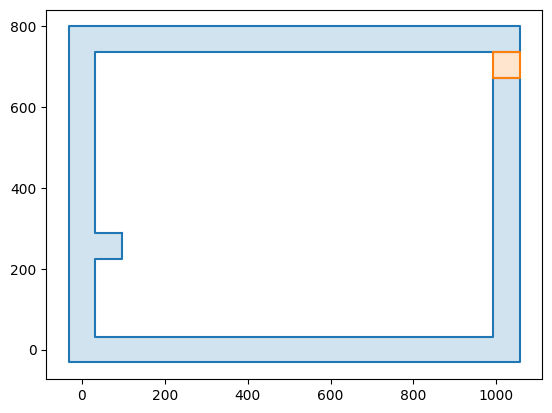

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 51
shape_a [[-32, 736], [-32, 672], [-32, 608], [-32, 544], [-32, 480], [-32, 416], [32, -32], [96, -32], [160, -32], [224, -32], [288, -32], [352, -32], [416, -32], [480, -32], [544, -32], [1056, 32], [1056, 96], [1056, 160], [1056, 224], [1056, 288], [992, 672], [992, 608], [992, 544], [992, 480], [992, 416], [992, 352], [992, 288], [992, 224], [992, 160], [992, 96], [992, 32], [928, 32], [864, 32], [800, 32], [736, 32], [672, 32], [608, 32], [544, 32], [480, 32], [416, 32], [352, 32], [288, 32], [224, 32], [160, 32], [96, 32], [32, 32], [32, 96], [32, 160], [32, 224], [32, 288], [32, 352], [32, 416], [32, 480]]
shape_b [[32, 480], [32, 544], [-32, 736]]
intersec : [[-32, 736], [32, 480]]
rest_a [[-32, 736], [-32, 672], [-32, 608], [-32, 544], [-32, 480], [-32, 416], [32, -32], [96, -32], [160, -32], [224, -32], [288, -32], [352, -32], [416, -32], [480, -32], [544, -32], [1056, 32], [1056, 96], [1056, 160], [1056, 224], [1056, 288], [992, 672], [992

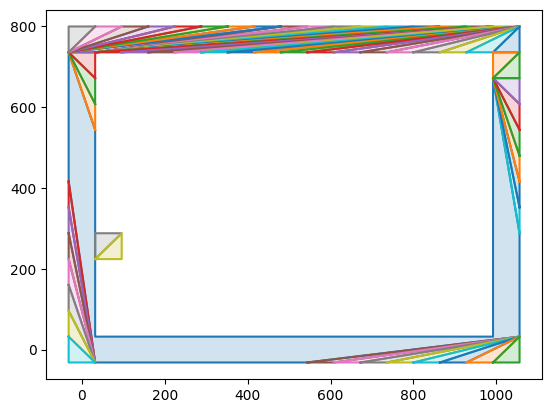

In [42]:
shape_a = [[992, 672], [1056, 672], [1056, 736], [992, 736]]
# shape_b = [(96, 288), (32, 288), (32, 736), (1056, 736), (1056, 800), (-32, 800), (-32, -32), (1056, -32), (1056, 672), (992, 672), (992, 32), (32, 32), (32, 224), (96, 224)]
shape_b = [[96, 288], [32, 288], [32, 352], [32, 416], [32, 480], [32, 544], [32, 608], [32, 672], [32, 736], [96, 736], [160, 736], [224, 736], [288, 736], [352, 736], [416, 736], [480, 736], [544, 736], [608, 736], [672, 736], [736, 736], [800, 736], [864, 736], [928, 736], [992, 736], [1056, 736], [1056, 800], [992, 800], [928, 800], [864, 800], [800, 800], [736, 800], [672, 800], [608, 800], [544, 800], [480, 800], [416, 800], [352, 800], [288, 800], [224, 800], [160, 800], [96, 800], [32, 800], [-32, 800], [-32, 736], [-32, 672], [-32, 608], [-32, 544], [-32, 480], [-32, 416], [-32, 352], [-32, 288], [-32, 224], [-32, 160], [-32, 96], [-32, 32], [-32, -32], [32, -32], [96, -32], [160, -32], [224, -32], [288, -32], [352, -32], [416, -32], [480, -32], [544, -32], [608, -32], [672, -32], [736, -32], [800, -32], [864, -32], [928, -32], [992, -32], [1056, -32], [1056, 32], [1056, 96], [1056, 160], [1056, 224], [1056, 288], [1056, 352], [1056, 416], [1056, 480], [1056, 544], [1056, 608], [1056, 672], [992, 672], [992, 608], [992, 544], [992, 480], [992, 416], [992, 352], [992, 288], [992, 224], [992, 160], [992, 96], [992, 32], [928, 32], [864, 32], [800, 32], [736, 32], [672, 32], [608, 32], [544, 32], [480, 32], [416, 32], [352, 32], [288, 32], [224, 32], [160, 32], [96, 32], [32, 32], [32, 96], [32, 160], [32, 224], [96, 224]]
draw(shape_b, shape_a)

chunk = [shape_a, shape_b]
draw(*test_convexes(chunk, 50))

In [17]:
leftover = [(1, 1), (0, 1), (1, 2)]
print(convex_hull(leftover))

[(1, 1), (1, 2), (0, 1)]


chunk of boxes


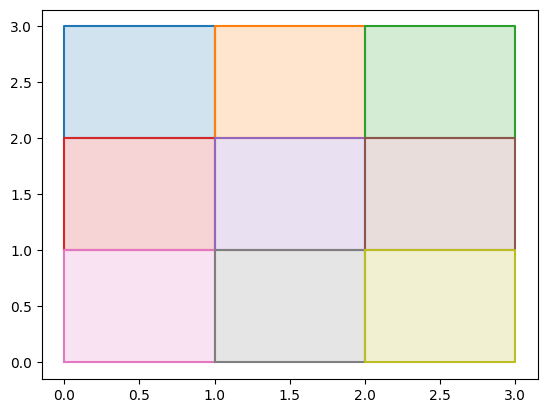

points in segment reduced


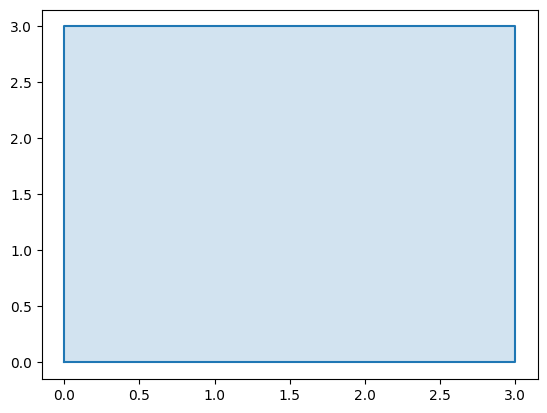

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 1
shape_a [(3, 1), (2, 1), (3, 0)]
shape_b [(2, 1), (2, 0), (3, 0)]
intersec : [(2, 1), (3, 0)]
rest_a [(3, 0), (3, 1)]
rest_b [(2, 1), (2, 0)]


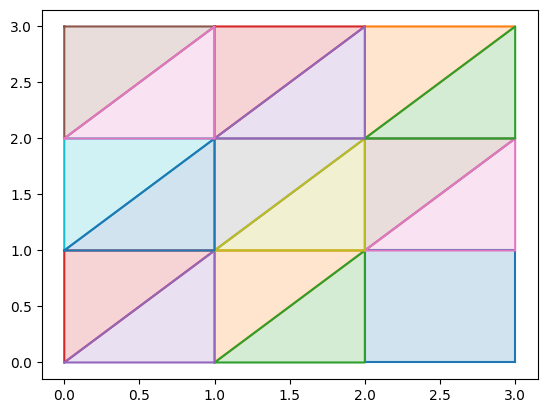

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 2
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 1), (1, 0), (2, 1)]
intersec : [(2, 1)]
shape_a [(3, 0), (3, 1), (2, 1), (2, 0)]
shape_b [(1, 0), (2, 0), (2, 1)]
intersec : [(2, 1), (2, 0)]
rest_a [(2, 0), (3, 0), (3, 1)]
rest_b [(2, 1), (1, 0)]
points in segment reduced


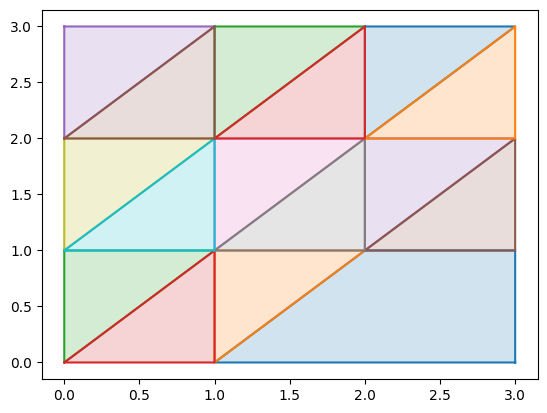

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 3
shape_a [(2, 0), (3, 0), (3, 1), (2, 1), (1, 0)]
shape_b [(1, 1), (1, 0), (2, 1)]
intersec : [(2, 1), (1, 0)]
rest_a [(1, 0), (2, 0), (3, 0), (3, 1)]
rest_b [(2, 1), (1, 1)]
points in segment reduced


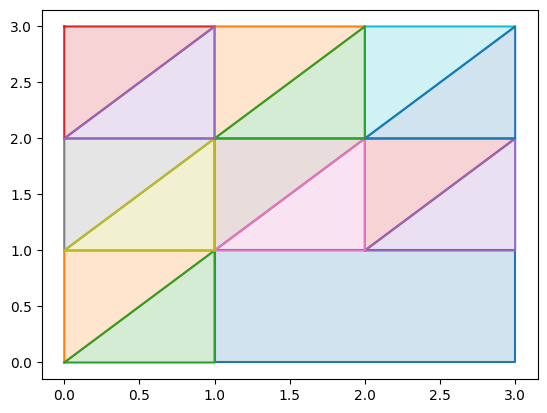

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 4
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(0, 1), (0, 0), (1, 1)]
intersec : [(1, 1)]
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1)]
shape_b [(0, 0), (1, 0), (1, 1)]
intersec : [(1, 0), (1, 1)]
rest_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1)]
rest_b [(1, 1), (0, 0)]
points in segment reduced


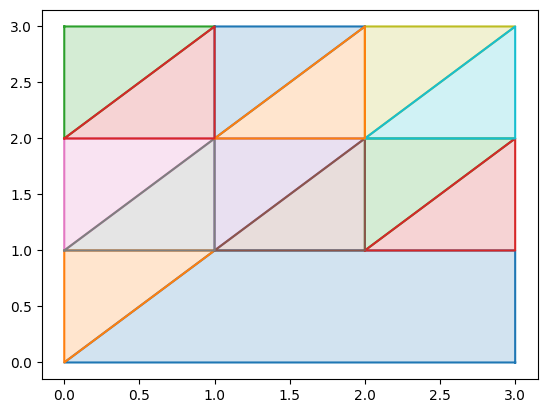

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 5
shape_a [(1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1), (0, 0)]
shape_b [(0, 1), (0, 0), (1, 1)]
intersec : [(1, 1), (0, 0)]
rest_a [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1)]
rest_b [(1, 1), (0, 1)]
points in segment reduced


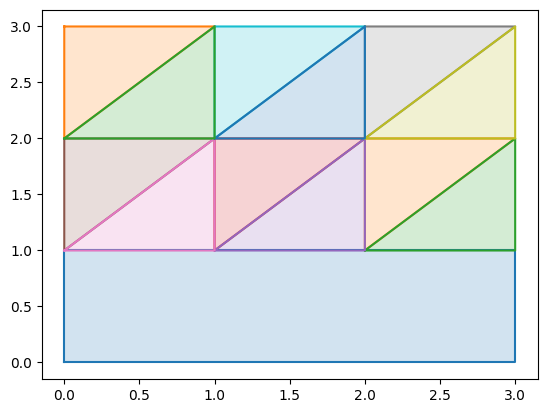

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 6
shape_a [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1), (0, 1)]
shape_b [(2, 2), (2, 1), (3, 2)]
intersec : [(2, 1)]
shape_a [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (2, 1), (1, 1), (0, 1)]
shape_b [(2, 1), (3, 1), (3, 2)]
intersec : [(3, 1), (2, 1)]
rest_a [(2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0)]
rest_b [(3, 1), (3, 2)]
points in segment reduced


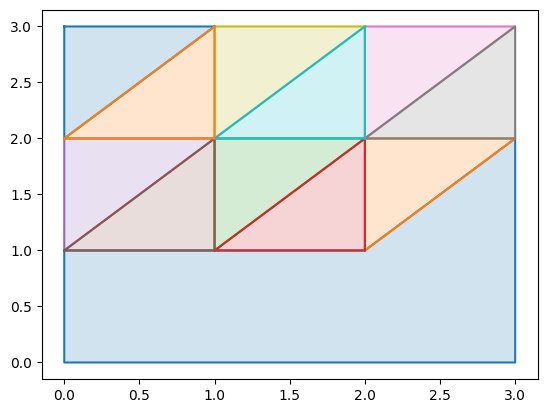

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 7
shape_a [(2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2)]
shape_b [(2, 2), (2, 1), (3, 2)]
intersec : [(2, 1), (3, 2)]
rest_a [(2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1)]
rest_b [(3, 2), (2, 2)]
points in segment reduced


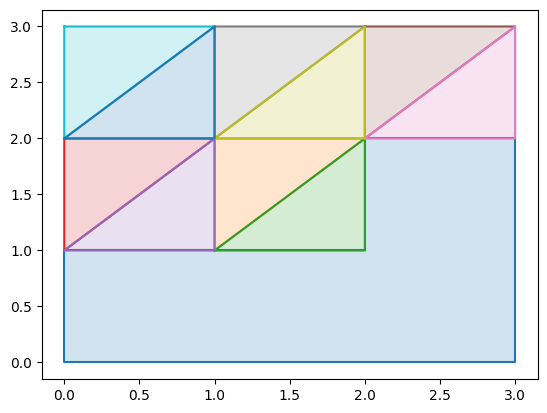

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 8
shape_a [(2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : [(1, 1), (2, 2)]
shape_a [(2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2)]
shape_b [(1, 1), (2, 1), (2, 2)]
intersec : [(2, 1), (1, 1), (2, 2)]
intersec reduced to [(1, 1), (2, 2)]
rest_a [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2)]
rest_b [(2, 2)]
points in segment reduced


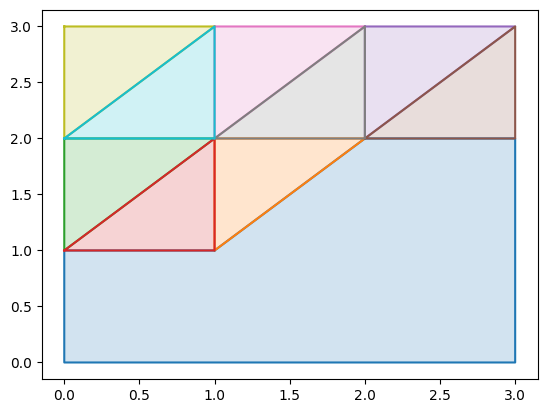

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 9
shape_a [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2)]
shape_b [(1, 2), (1, 1), (2, 2)]
intersec : [(1, 1), (2, 2)]
rest_a [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2)]
rest_b [(2, 2), (1, 2)]
points in segment reduced


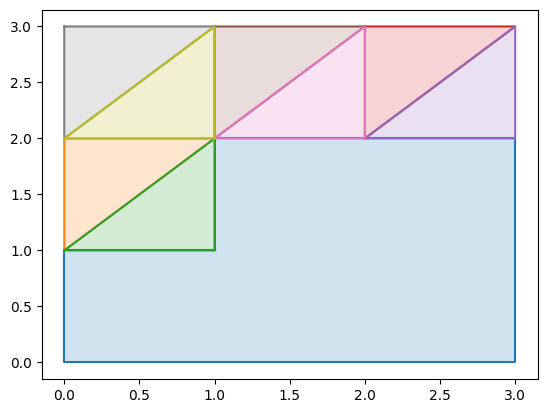

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 10
shape_a [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : [(0, 1), (1, 2)]
shape_a [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2)]
shape_b [(0, 1), (1, 1), (1, 2)]
intersec : [(1, 1), (0, 1), (1, 2)]
intersec reduced to [(0, 1), (1, 2)]
rest_a [(0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2)]
rest_b [(1, 2)]
points in segment reduced


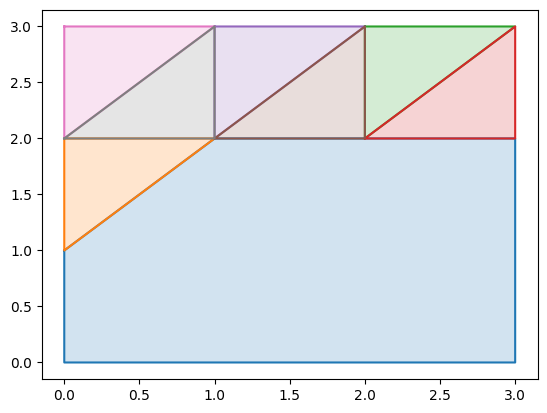

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 11
shape_a [(0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2)]
shape_b [(0, 2), (0, 1), (1, 2)]
intersec : [(0, 1), (1, 2)]
rest_a [(0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2)]
rest_b [(1, 2), (0, 2)]
points in segment reduced


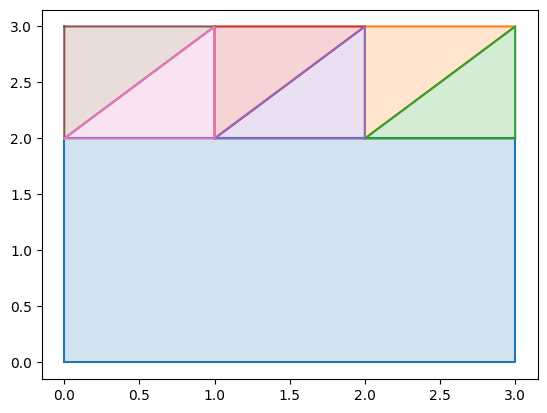

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 12
shape_a [(0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2)]
shape_b [(2, 3), (2, 2), (3, 3)]
intersec : [(2, 2)]
shape_a [(0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2)]
shape_b [(2, 2), (3, 2), (3, 3)]
intersec : [(3, 2), (2, 2)]
rest_a [(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1)]
rest_b [(3, 2), (3, 3)]
points in segment reduced


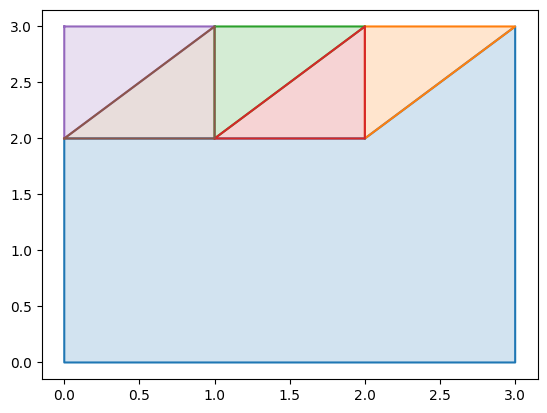

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 13
shape_a [(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3)]
shape_b [(2, 3), (2, 2), (3, 3)]
intersec : [(2, 2), (3, 3)]
rest_a [(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2)]
rest_b [(3, 3), (2, 3)]
points in segment reduced


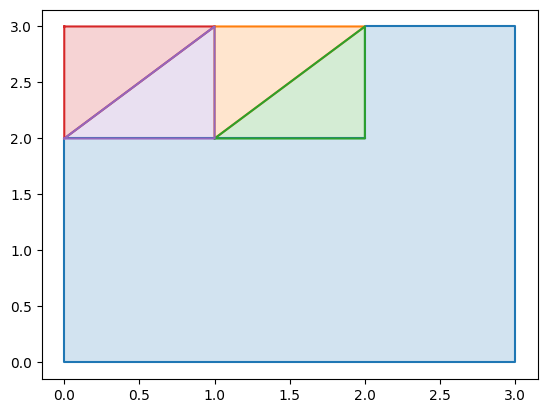

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 14
shape_a [(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3)]
shape_b [(1, 3), (1, 2), (2, 3)]
intersec : [(1, 2), (2, 3)]
shape_a [(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3)]
shape_b [(1, 2), (2, 2), (2, 3)]
intersec : [(2, 2), (1, 2), (2, 3)]
intersec reduced to [(1, 2), (2, 3)]
rest_a [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3)]
rest_b [(2, 3)]
points in segment reduced


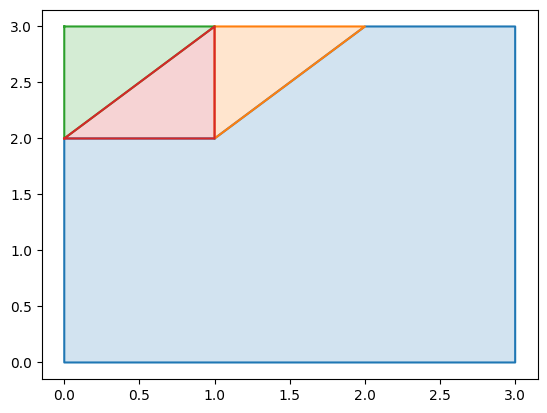

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 15
shape_a [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3)]
shape_b [(1, 3), (1, 2), (2, 3)]
intersec : [(1, 2), (2, 3)]
rest_a [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3)]
rest_b [(2, 3), (1, 3)]
points in segment reduced


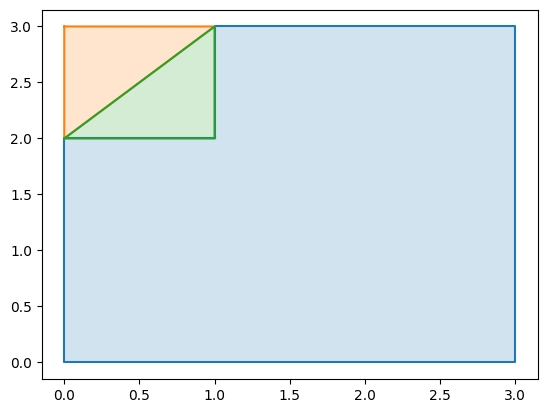

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 16
shape_a [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
shape_b [(0, 3), (0, 2), (1, 3)]
intersec : [(0, 2), (1, 3)]
shape_a [(1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
shape_b [(0, 2), (1, 2), (1, 3)]
intersec : [(1, 2), (0, 2), (1, 3)]
intersec reduced to [(0, 2), (1, 3)]
rest_a [(0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3)]
rest_b [(1, 3)]
points in segment reduced


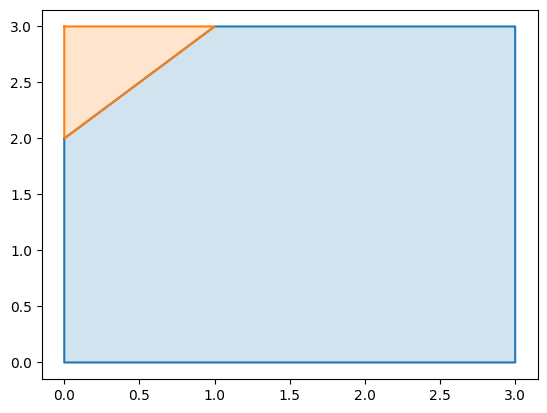

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 17
shape_a [(0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3)]
shape_b [(0, 3), (0, 2), (1, 3)]
intersec : [(0, 2), (1, 3)]
rest_a [(0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3)]
rest_b [(1, 3), (0, 3)]
points in segment reduced


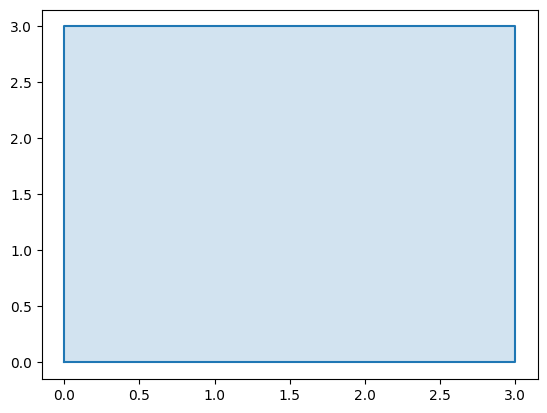

In [54]:
### test over nested boxes
b1 = [v(0,0), v(1,0), v(1,1), v(0,1)]   # 1 down-left
b2 = [v(1,0), v(2,0), v(2,1), v(1,1)]   # 2 down
b3 = [v(1,1), v(2,1), v(2,2), v(1,2)]   # 5 center
b4 = [v(0,1), v(1,1), v(1,2), v(0,2)]   # 4 left
b5 = [v(2,1), v(2,0), v(3,0), v(3,1)]   # 3 down-right
b6 = [v(2,1), v(3,1), v(3,2), v(2,2)]   # 6 right
b7 = [v(2,2), v(3,2), v(3,3), v(2,3)]   # 9 up-right
b8 = [v(1,2), v(2,2), v(2,3), v(1,3)]   # 8 up
b9 = [v(0,2), v(1,2), v(1,3), v(0,3)]   # 7 up-left
chunk = [b9, b8, b7, b4, b3, b6, b1, b2, b5]
# chunk = [b1, b2, b5, b4, b6, b9, b8, b7]
# chunk = [b1, b2, b4, b6, b8, b7]
draw(*chunk, title = 'chunk of boxes')
draw(*test_convexes(chunk))
for i in range(17):
    draw(*test_convexes(chunk, i))



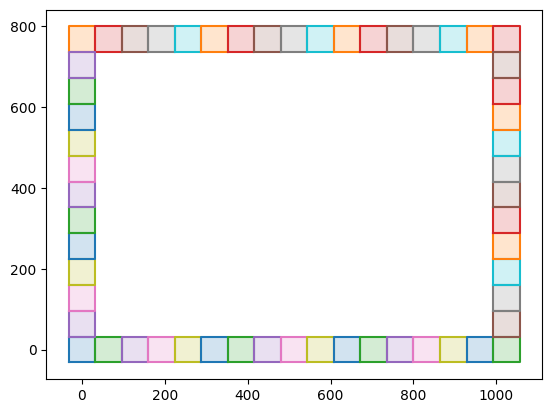

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 110
shape_a [[32, -32], [96, -32], [160, -32], [224, -32], [288, -32], [352, -32], [416, -32], [480, -32], [544, -32], [608, -32], [672, -32], [736, -32], [800, -32], [864, -32], [928, -32], [992, -32], [1056, -32], [1056, 32], [1056, 96], [1056, 160], [1056, 224], [1056, 288], [1056, 352], [1056, 416], [1056, 480], [1056, 544], [1056, 608], [1056, 672], [1056, 736], [1056, 800], [992, 800], [928, 800], [864, 800], [800, 800], [736, 800], [672, 800], [608, 800], [544, 800], [480, 800], [416, 800], [352, 800], [288, 800], [224, 800], [160, 800], [96, 800], [32, 800], [-32, 800], [-32, 736], [-32, 672], [-32, 608], [-32, 544], [-32, 480], [-32, 416], [-32, 352], [-32, 288], [-32, 224], [-32, 160], [-32, 96], [-32, 32], [32, 96], [32, 160], [32, 224], [32, 288], [32, 352], [32, 416], [32, 480], [32, 544], [32, 608], [32, 672], [32, 736], [96, 736], [160, 736], [224, 736], [288, 736], [352, 736], [416, 736], [480, 736], [544, 736], [608, 736], [672, 736],

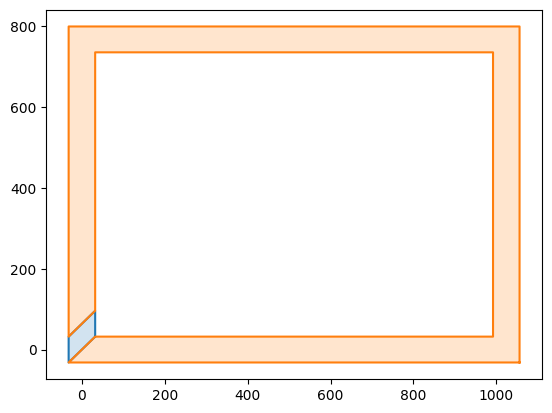

In [60]:
real_world_problem = [[[-32, -32], [32, -32], [32, 32], [-32, 32]], [[-32, 736], [32, 736], [32, 800], [-32, 800]], [[32, -32], [96, -32], [96, 32], [32, 32]], [[32, 736], [96, 736], [96, 800], [32, 800]], [[96, -32], [160, -32], [160, 32], [96, 32]], [[96, 736], [160, 736], [160, 800], [96, 800]], [[160, -32], [224, -32], [224, 32], [160, 32]], [[160, 736], [224, 736], [224, 800], [160, 800]], [[224, -32], [288, -32], [288, 32], [224, 32]], [[224, 736], [288, 736], [288, 800], [224, 800]], [[288, -32], [352, -32], [352, 32], [288, 32]], [[288, 736], [352, 736], [352, 800], [288, 800]], [[352, -32], [416, -32], [416, 32], [352, 32]], [[352, 736], [416, 736], [416, 800], [352, 800]], [[416, -32], [480, -32], [480, 32], [416, 32]], [[416, 736], [480, 736], [480, 800], [416, 800]], [[480, -32], [544, -32], [544, 32], [480, 32]], [[480, 736], [544, 736], [544, 800], [480, 800]], [[544, -32], [608, -32], [608, 32], [544, 32]], [[544, 736], [608, 736], [608, 800], [544, 800]], [[608, -32], [672, -32], [672, 32], [608, 32]], [[608, 736], [672, 736], [672, 800], [608, 800]], [[672, -32], [736, -32], [736, 32], [672, 32]], [[672, 736], [736, 736], [736, 800], [672, 800]], [[736, -32], [800, -32], [800, 32], [736, 32]], [[736, 736], [800, 736], [800, 800], [736, 800]], [[800, -32], [864, -32], [864, 32], [800, 32]], [[800, 736], [864, 736], [864, 800], [800, 800]], [[864, -32], [928, -32], [928, 32], [864, 32]], [[864, 736], [928, 736], [928, 800], [864, 800]], [[928, -32], [992, -32], [992, 32], [928, 32]], [[928, 736], [992, 736], [992, 800], [928, 800]], [[992, -32], [1056, -32], [1056, 32], [992, 32]], [[992, 736], [1056, 736], [1056, 800], [992, 800]], [[-32, 32], [32, 32], [32, 96], [-32, 96]], [[992, 32], [1056, 32], [1056, 96], [992, 96]], [[-32, 96], [32, 96], [32, 160], [-32, 160]], [[992, 96], [1056, 96], [1056, 160], [992, 160]], [[-32, 160], [32, 160], [32, 224], [-32, 224]], [[992, 160], [1056, 160], [1056, 224], [992, 224]], [[-32, 224], [32, 224], [32, 288], [-32, 288]], [[992, 224], [1056, 224], [1056, 288], [992, 288]], [[-32, 288], [32, 288], [32, 352], [-32, 352]], [[992, 288], [1056, 288], [1056, 352], [992, 352]], [[-32, 352], [32, 352], [32, 416], [-32, 416]], [[992, 352], [1056, 352], [1056, 416], [992, 416]], [[-32, 416], [32, 416], [32, 480], [-32, 480]], [[992, 416], [1056, 416], [1056, 480], [992, 480]], [[-32, 480], [32, 480], [32, 544], [-32, 544]], [[992, 480], [1056, 480], [1056, 544], [992, 544]], [[-32, 544], [32, 544], [32, 608], [-32, 608]], [[992, 544], [1056, 544], [1056, 608], [992, 608]], [[-32, 608], [32, 608], [32, 672], [-32, 672]], [[992, 608], [1056, 608], [1056, 672], [992, 672]], [[-32, 672], [32, 672], [32, 736], [-32, 736]], [[992, 672], [1056, 672], [1056, 736], [992, 736]]]
draw(*real_world_problem)
# conv = test_convexes(real_world_problem, 50)
draw(*test_convexes(real_world_problem, 109))
# draw(*conv)
# conv.reverse()
# tris = triangulate_all(conv)
# draw(*tris)
# draw(*convexise(tris))
# draw(*conv)

four boxes


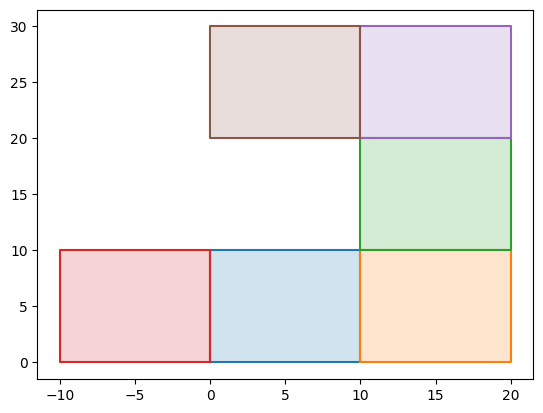

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 1
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 2
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 4
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 6
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 7
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 8
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 9
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 10
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 11
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 12
points in segment reduced


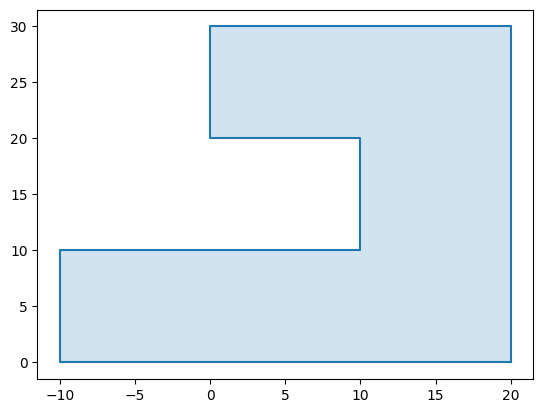

making convex hull by raw points


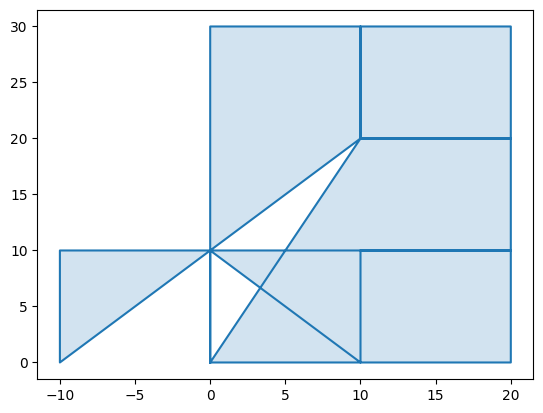

convex hull with processed points
points in segment reduced


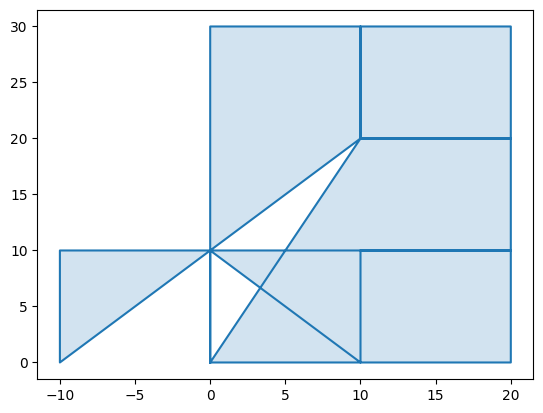

convexised


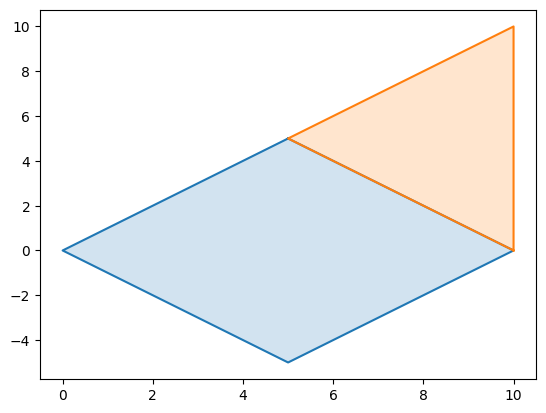

In [31]:

print('four boxes')
draw(*boxes)
draw(*test_convexes(boxes))
print('making convex hull by raw points')
draw(pts)

print('convex hull with processed points')
draw(check_point_on_segment(pts))

nt=[[v(0,0), v(10,0), v(5,5)], 
    [v(5,-5), v(10,0), v(0,0)],
    [v(10,0), v(10,10), v(5,5)]]

print('convexised')
draw(*convexise(nt))


[[(0, 0), (5, -5), (10, 0)], [(10, 0), (10, 10), (5, 5)], [(0, 0), (10, 0), (5, 5)]]
triangulated 사다리꼴


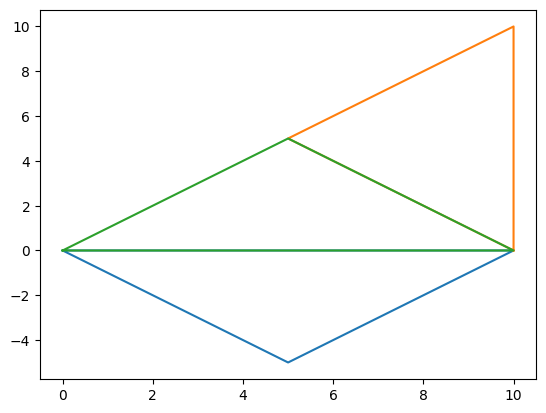

reconvexised 사다리꼴
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 1
hulls : [[(0, 0), (5, -5), (10, 0), (5, 5)], [(10, 0), (10, 10), (5, 5)]]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 2
hulls : [[(5, 5), (0, 0), (5, -5), (10, 0), (10, 10)]]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> step 3
hulls : [[(5, 5), (0, 0), (5, -5), (10, 0), (10, 10)]]
points in segment reduced


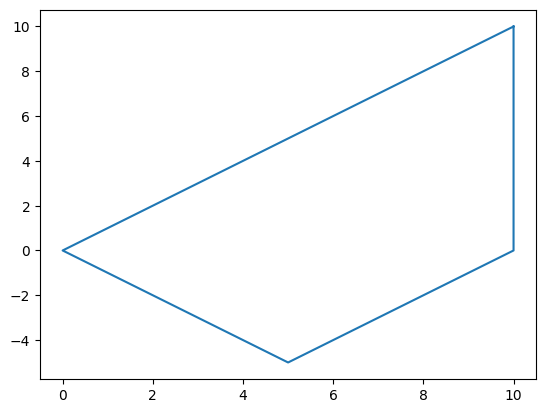

triangles #2


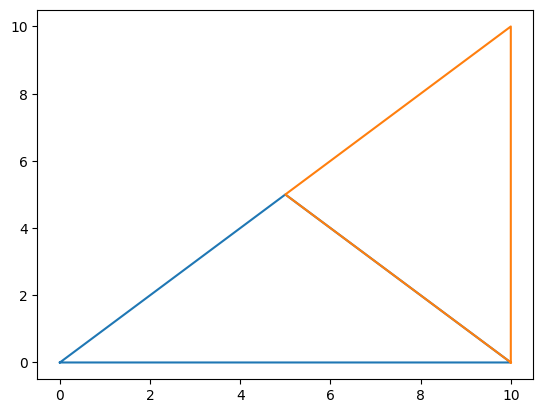

convexised #2


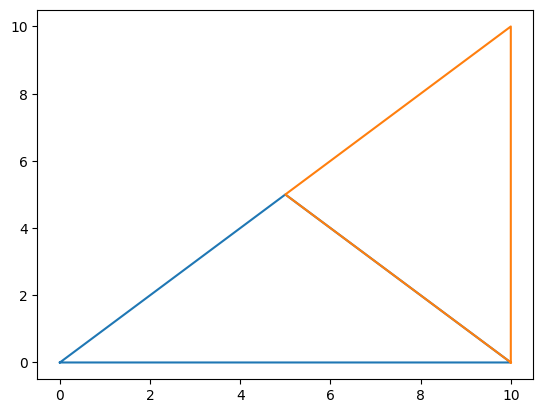

<Figure size 640x480 with 0 Axes>

[]


<Figure size 640x480 with 0 Axes>

In [ ]:

np = [v(0,0), v(5,-5), v(10,0), v(10,10), v(5,5)]
npt = triangulate(np)
print(npt)
print('triangulated 사다리꼴')
draw(*npt)
print('reconvexised 사다리꼴')
draw(*test_convexes(npt))

nt = [
    [v(0,0), v(10,0), v(5,5)],
    [v(10,0), v(10,10),v(5,5)]
]
print('triangles #2')
draw(*nt)
print('convexised #2')
draw(*convexise(nt))

tri = []
for sh in d:
    tri.extend(triangulate(sh))
draw(*tri)
print(tri)

cov = convexise(tri)
draw(*cov)

